Importation des bibliothèques utiles

In [3]:
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from zipfile import ZipFile
file_name1 = "/content/drive/My Drive/dataset/WISDM-dataset.zip" 
file_name2 = "/content/drive/My Drive/dataset/HAR-Data-segment.zip" 

In [6]:
with ZipFile(file_name1, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [7]:
with ZipFile(file_name2, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Existing fuctions

In [8]:
def readData(filePath):
  # attributes of the dataset
  columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
  data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
  return data

In [9]:
def plotAxis(axis,x,y,title):
  axis.plot(x,y)
  axis.set_title(title)
  axis.xaxis.set_visible(False)
  axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
  axis.set_xlim([min(x),max(x)])
  axis.grid(True)

In [10]:
# defining a function to plot the data for a given activity
def plotActivity(activity,data):
  fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
  plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
  plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
  plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
  plt.subplots_adjust(hspace=0.2)
  fig.suptitle(activity)
  plt.subplots_adjust(top=0.9)
  plt.show()

Read actitracker_rax.txt data

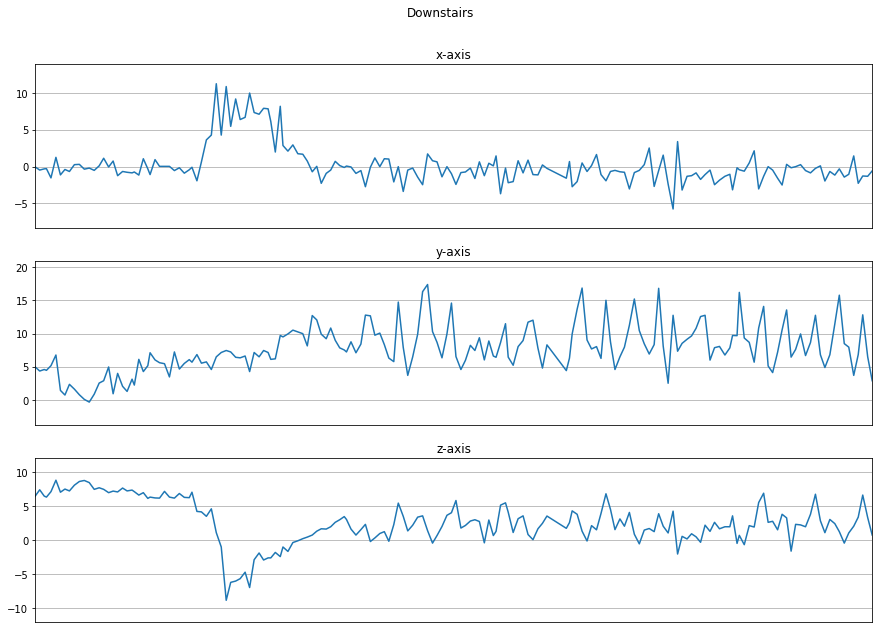

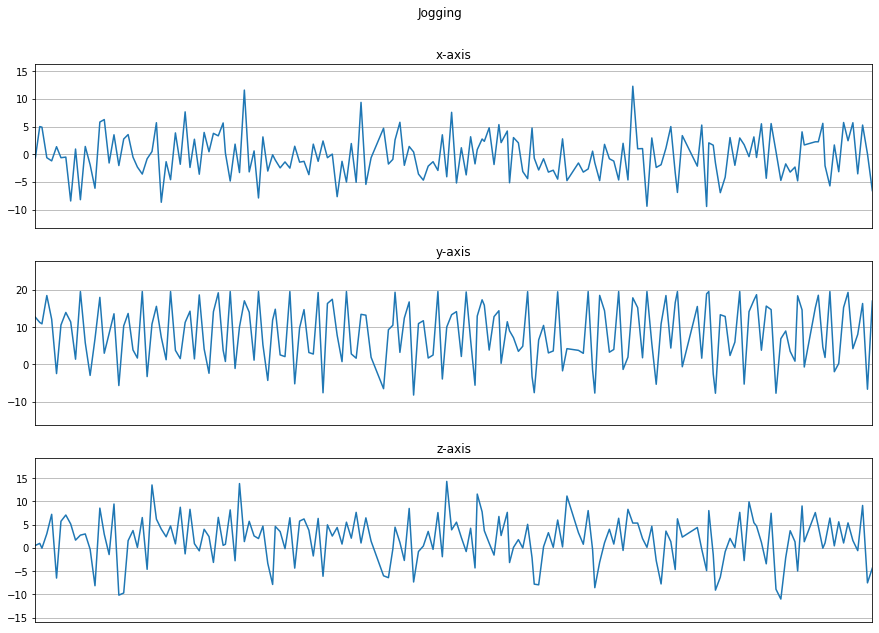

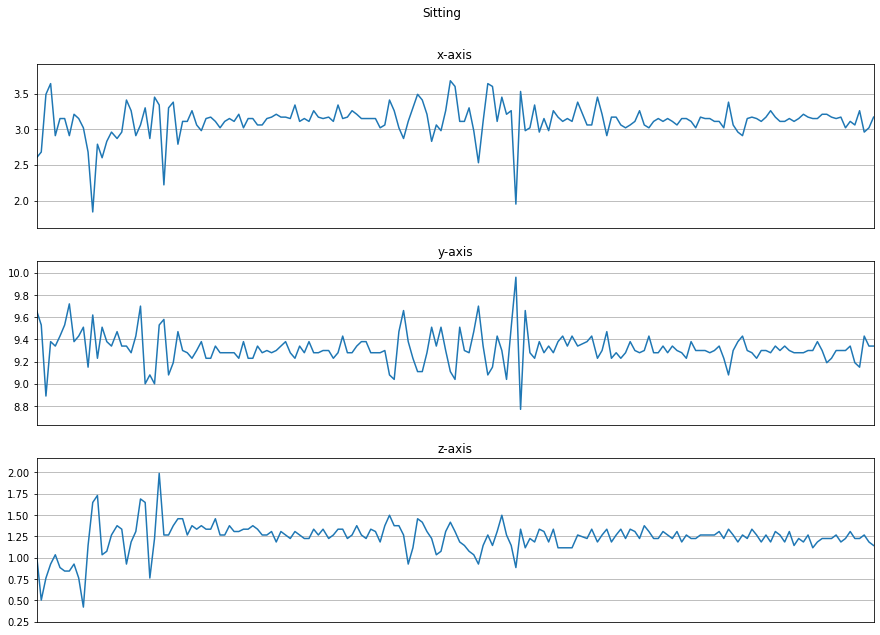

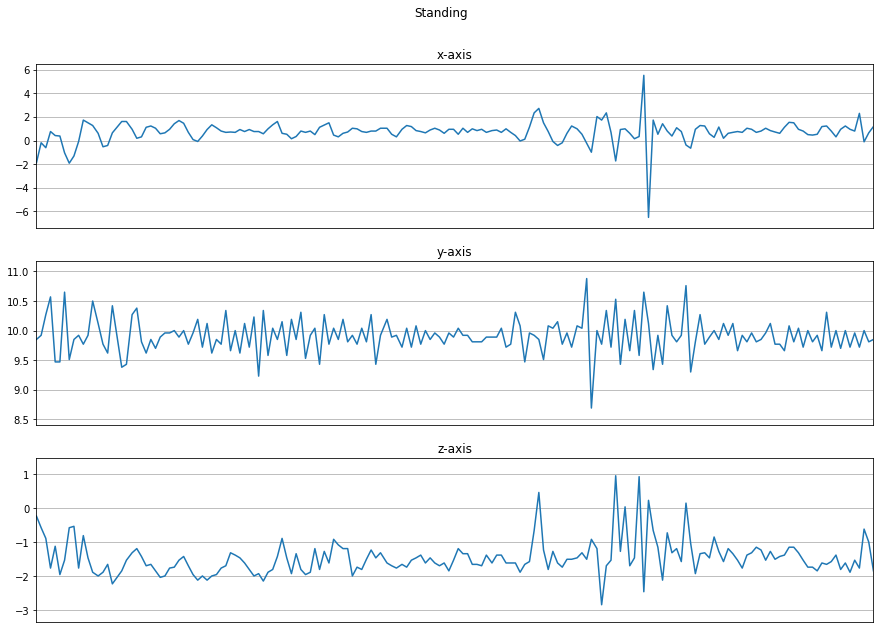

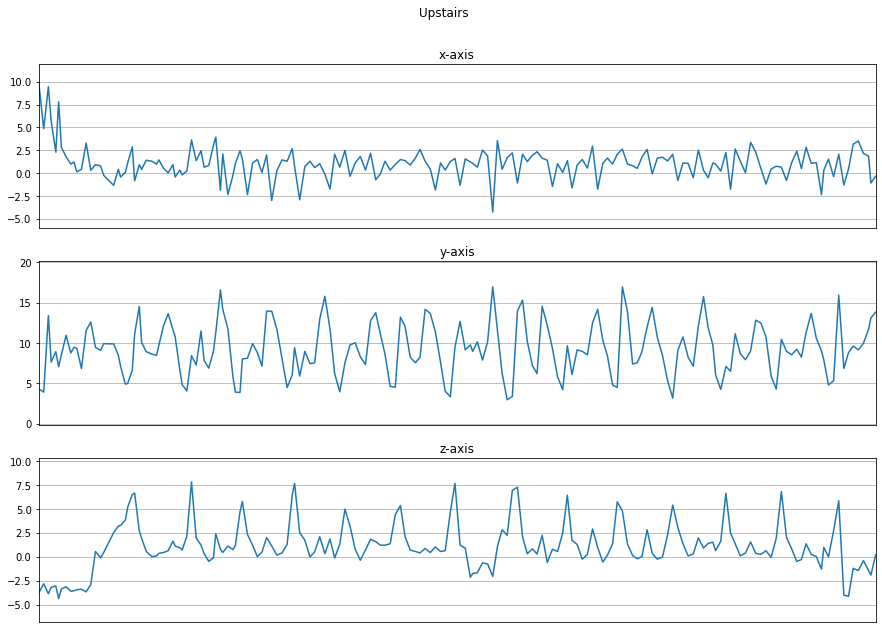

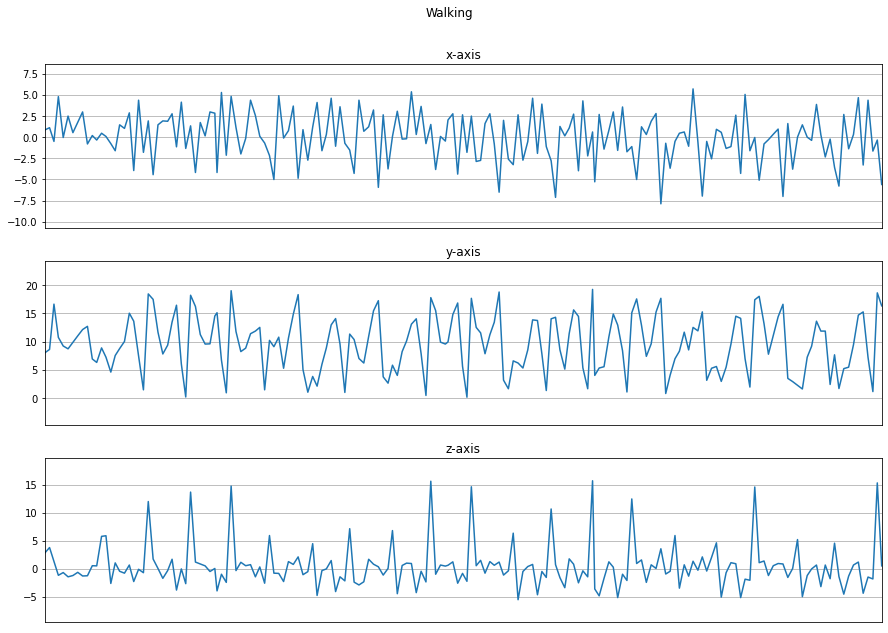

In [9]:
dataset = readData('./actitracker_raw.txt')
# plotting a subset of the data to visualize
for activity in np.unique(dataset['activity']):
  subset = dataset[dataset['activity']==activity][:180]
  plotActivity(activity,subset)

Other functions

In [11]:
def windows(data,size):
  start = 0
  while start< data.count():
    yield int(start), int(start + size)
    start+= (size/2)

In [12]:
# segmenting the time series
def segment_signal(data, window_size = 90):
  segments = np.empty((0,window_size,3))
  labels= np.empty((0))
  for (start, end) in windows(data['timestamp'],window_size):
    x = data['x-axis'][start:end]
    y = data['y-axis'][start:end]
    z = data['z-axis'][start:end]
    if(len(data['timestamp'][start:end])==window_size):
      segments = np.vstack([segments,np.dstack([x,y,z])])
      labels =np.append(labels,stats.mode(data['activity'][start:end])[0][0])
  return segments, labels

1/ Convolutional Neural Network (2D CNN)

In [13]:
dataset = readData("./actitracker_raw.txt")
features_name = ["x-axis","y-axis","z-axis"]
for name in features_name:
  dataset[name] = (dataset[name]-dataset[name].mean())/dataset[name].std()

res = segment_signal(dataset)

segments = np.load("./segments.npy")
y = np.load("./labels.npy")

segments = np.nan_to_num(segments)
y = np.nan_to_num(y)

activities = ['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

In [41]:
X = segments.reshape(segments.shape[0], segments.shape[1],segments.shape[2],1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (19522, 90, 3, 1)
Shape of validation images is: (4881, 90, 3, 1)
Shape of labels is: (19522, 6)
Shape of labels is: (4881, 6)


In [42]:
model = models.Sequential()# (1)
model.add(layers.Conv2D(128, (2, 2), activation='relu',input_shape=(90,3,1)))#(2)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())# (4)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 89, 2, 128)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 44, 1, 128)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 1, 128)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               721024    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                

In [34]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[0]
print(n_timesteps)
print(n_features)
print(n_outputs)

90
3
19522


In [48]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

#Fit the model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2,
                    verbose=2
                    )

Epoch 1/10
489/489 - 8s - loss: 0.2991 - acc: 0.8876 - val_loss: 0.3221 - val_acc: 0.8773
Epoch 2/10
489/489 - 8s - loss: 0.2707 - acc: 0.8983 - val_loss: 0.3322 - val_acc: 0.8799
Epoch 3/10
489/489 - 8s - loss: 0.2548 - acc: 0.9036 - val_loss: 0.2965 - val_acc: 0.8986
Epoch 4/10
489/489 - 8s - loss: 0.2455 - acc: 0.9069 - val_loss: 0.3210 - val_acc: 0.8901
Epoch 5/10
489/489 - 8s - loss: 0.2168 - acc: 0.9182 - val_loss: 0.3023 - val_acc: 0.8960
Epoch 6/10
489/489 - 8s - loss: 0.2121 - acc: 0.9226 - val_loss: 0.3016 - val_acc: 0.8988
Epoch 7/10
489/489 - 8s - loss: 0.2016 - acc: 0.9253 - val_loss: 0.3206 - val_acc: 0.8991
Epoch 8/10
489/489 - 8s - loss: 0.1891 - acc: 0.9296 - val_loss: 0.3066 - val_acc: 0.8971
Epoch 9/10
489/489 - 8s - loss: 0.1735 - acc: 0.9381 - val_loss: 0.3020 - val_acc: 0.9060
Epoch 10/10
489/489 - 8s - loss: 0.1682 - acc: 0.9372 - val_loss: 0.3080 - val_acc: 0.9009


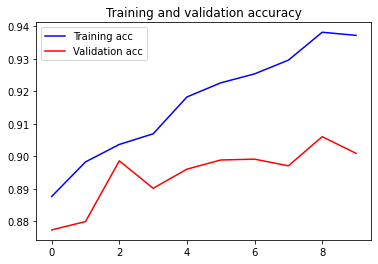

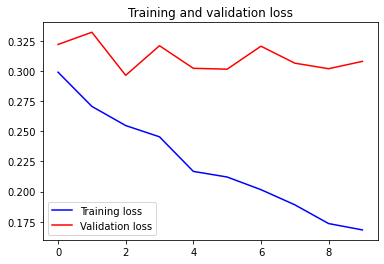

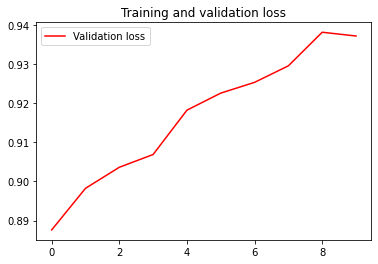

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history.history['loss']
acc = history.history['acc']
epochs = range(len(acc))
plt.figure()

plt.plot(epochs,acc, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
# evaluating and printing results
score = model.evaluate(X_val, y_val, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.2877594828605652
Test Accuracy: 0.8996107578277588


2/ Long-Short-Terms-Memory (LSTM)

In [14]:
segments = np.load("./segments.npy")
y2 = np.load("./labels.npy")

segments = np.nan_to_num(segments)

X2=segments
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.20, random_state=2)

In [15]:
model2 = models.Sequential()# (1)
model2.add(layers.LSTM(128, input_shape=(90,3), return_sequences=True))
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization())
model2.add(layers.LSTM(128))# (4)
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(6, activation='softmax'))

model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

ntrain = len(X2_train)
nval = len(X2_val)
batch_size = 32

#Fit the model
history2 = model2.fit(X2_train,y2_train,batch_size=batch_size,epochs=10,validation_split=0.2,verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 128)           67584     
_________________________________________________________________
dropout (Dropout)            (None, 90, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4

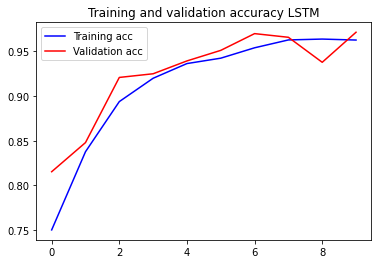

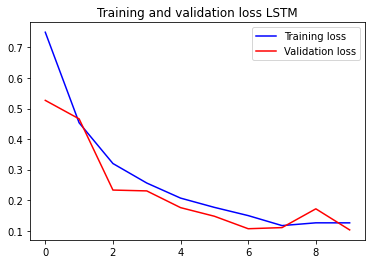

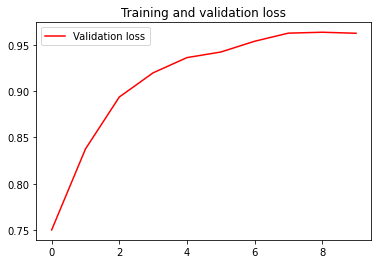

In [25]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss LSTM')
plt.legend()
plt.show()

loss = history2.history['loss']
acc = history2.history['acc']
epochs = range(len(acc))
plt.figure()

plt.plot(epochs,acc, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
# evaluating and printing results
score2 = model2.evaluate(X2_val, y2_val, verbose=0)
print('Test Loss:', score2[0])
print('Test Accuracy:', score2[1])

Test Loss: 0.08571254462003708
Test Accuracy: 0.9737758636474609


We see that all the two networks perform well but LSTM has a better accuracy than CNN. 

3/ Convolutional Neural Network (1D CNN)

In [27]:
segments = np.load("./segments.npy")
y = np.load("./labels.npy")

segments = np.nan_to_num(segments)

X=segments
X3_train, X3_val, y3_train, y3_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [ ]:
print(X.shape)

(24403, 90, 3)


In [28]:
from keras.layers import Conv1D

model3 = models.Sequential()
model3.add(Conv1D(100, kernel_size=10, input_shape = (90, 3)))
model3.add(Conv1D(100, kernel_size=10))
model3.add(layers.MaxPooling1D((3)))
model3.add(Conv1D(160, kernel_size=10))
model3.add(Conv1D(160, kernel_size=10))
model3.add(layers.GlobalAveragePooling1D())
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(6, activation='softmax'))

model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history3 = model3.fit(X3_train,y3_train,batch_size=32,epochs=10,validation_split=0.2,verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 81, 100)           3100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 100)           100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 160)           160160    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 160)            256160    
_________________________________________________________________
global_average_pooling1d (Gl (None, 160)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)              

In [29]:
# evaluating and printing results
score3 = model3.evaluate(X3_val, y3_val, verbose=0)
print('Test Loss:', score3[0])
print('Test Accuracy:', score3[1])

Test Loss: 0.2510916292667389
Test Accuracy: 0.9215324521064758


LSTM has a better accuracy than 1D CNN and 2D CNN but 1D CNN has a better accuracy than 2D CNN.